In [1]:
import pandas as pd
import akshare as ak
from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
from math import log
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# 整理模型所需要数据

In [26]:
def process(rate_name,fin_name,year):   
    mdata = pd.read_csv(rate_name)
    #将中债隐含评级数据换为数字
    mdata.loc[(mdata["F2_0003"]== 'AAA+'),"评级"] = 10
    mdata.loc[(mdata["F2_0003"]== 'AAA')  ,"评级"] = 9
    mdata.loc[(mdata["F2_0003"]== 'AA+')|(mdata["F2_0003"]== 'AAA-')  ,"评级"] = 8
    mdata.loc[(mdata["F2_0003"]== 'AA')|(mdata["F2_0003"]== 'AA(2)'),"评级"] = 7
    mdata.loc[mdata["F2_0003"]== 'AA-',"评级"] = 6
    mdata.loc[(mdata["F2_0003"]== 'A+')  ,"评级"] = 5
    mdata.loc[(mdata["F2_0003"]== 'A'),"评级"] = 4
    mdata.loc[(mdata["F2_0003"]== 'A-'),"评级"] = 3
    mdata.loc[(mdata["F2_0003"]== 'BBB+') |( mdata["F2_0003"]== 'BBB')|( mdata["F2_0003"]== 'BBB-') ,"评级"] = 2
    mdata.loc[(mdata["F2_0003"]== 'BB') |( mdata["F2_0003"]== 'B') ,"评级"] = 1
    mdata.loc[(mdata["F2_0003"]== 'CCC') |( mdata["F2_0003"]== 'CC')|( mdata["F2_0003"]== 'C') ,"评级"] = 0
    #比较年初年末的中债数据
    first_date = min(mdata["F1_2014"])
    first = mdata.loc[mdata["F1_2014"] ==first_date ]
    final_date = max(mdata["F1_2014"])
    final = mdata.loc[mdata["F1_2014"] ==final_date ]
    #关联年末年初的数据表
    data = pd.merge(first,final,on = "OB_OBJECT_NAME_1090")
    #如果数据下降则下降等于1
    data.loc[(data['评级_x']> data['评级_y']),"下降"] = 1
    data.loc[(data['评级_x']< 3),"下降"] = 1
    fin_data = pd.read_csv(fin_name)
    #和发债主体的财务数据相关联
    data = pd.merge(bond,data,left_on  ="secu_cd",right_on = "F16_1090_x")
    data = pd.merge(fin_data,data,left_on ="corp_id",right_on = "issr_id")
    data_defualt = data.loc[data["下降"]==1]
    default_company = data_defualt["issr_id"].unique()
    company = data["issr_id"].unique()
    bond_data = pd.DataFrame()
    bond_data["ID"] = company
    bond_data.loc[bond_data["ID"].isin(default_company) == 1  ,"下降"] = 1
    bond_data["下降"] =  bond_data["下降"].fillna(0)
    bond_data = pd.merge(bond_data,fin_data,left_on = "ID",right_on = "corp_id")
    bond_data = bond_data.dropna(subset=["ebitda"])
    bond_data = bond_data.fillna(0)
    
    start_year = year + "-01-01"
    end_year = year + "-12-31"
    true_defualt = pd.read_csv("bond_default.csv",encoding='gbk')
    true_defualt = pd.merge(true_defualt,bond,left_on = "SecuCode",right_on = "secu_cd")
    true_defualt = true_defualt.loc[(true_defualt["DefaultDate"]>start_year)&(true_defualt["DefaultDate"]<end_year)]
    true_default = true_defualt["issr_id"].unique()
    bond_data.loc[bond_data["ID"].isin(true_default) == 1  ,"真违约"] = 1
    bond_data["真违约"] = bond_data["真违约"].fillna(0)
    
   #整理要放入模型的数据
    model_data = pd.DataFrame()
    model_data["企业"] = bond_data["ID"]
    model_data["主营业务利润率"] = bond_data["biz_prof_biz_total_ncm_rt"]
    model_data["营业成本收入比"] = bond_data["biz_cost_ncm_rt"]
    model_data["总资产报酬率"] = bond_data["total_ast_rwrd_rate_ann"]
    model_data["总资产收益率"] = bond_data["total_ast_prft_rate"]
    model_data["应收账款周转率"] = bond_data["recv_acc_tr"]
    model_data["存货周转率"] = bond_data["invt_tr"]
    model_data["流动比率"] =bond_data["flow_rt"]
    model_data["速度比率"] = bond_data["qr"]
    model_data["EBITA/带息债务"] = bond_data["ebitda"]/(bond_data["st_brow"]+bond_data["lt_brow"])
    model_data["资产负债率"] = bond_data["ast_liab_rate"]
    model_data["短期债务/总债务"] = bond_data["flow_liab_tot"]/bond_data["liab_tot"]
    model_data["货币资金/总债务"] = bond_data["crrc_fund"]/bond_data["liab_tot"]
    model_data["货币资金/短期债务"] = bond_data["crrc_fund"]/bond_data["flow_liab_tot"]
    model_data["营业收入增长率"] = bond_data["biz_ncm_yoy_incr"]
    model_data["违约"] = bond_data["下降"]
    model_data["真违约"] = bond_data["真违约"]
    model_data =model_data.replace([np.inf, -np.inf], np.nan) 
    model_data = model_data.dropna()
    model_data = model_data.drop_duplicates(subset=["企业"] )
    return model_data

In [136]:
bond = pd.read_csv("new bond.csv")
data_2018 = process("2018 中债.csv","2018  data.csv","2018")
data_2019 = process("2019 中债.csv","2019  data.csv","2019")
data_2020 = process("2020 中债.csv","2020  data.csv","2020")
model_data = pd.concat([data_2018,data_2019,data_2020])
model_data.to_csv("model_data.csv")

# 展示数据

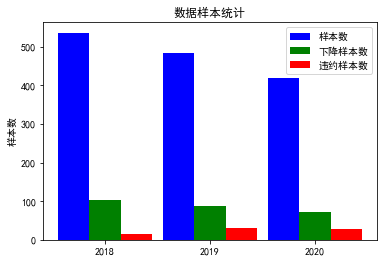

In [134]:
import matplotlib.pyplot as plt
import numpy as np
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 输入统计数据
waters = ("2018","2019","2020")
lenth = [len(data_2018),len(data_2019),len(data_2020)]
down = [sum(data_2018["违约"]),sum(data_2019["违约"]),sum(data_2020["违约"])]
default  = [sum(data_2018["真违约"]),sum(data_2019["真违约"]),sum(data_2020["真违约"])]
bar_width = 0.3 # 条形宽度
index_male = np.arange(len(waters)) 
index_female = index_male + bar_width
index_a = index_male + bar_width*2
# 使用两次 bar 函数画出两组条形图
plt.bar(index_male, height=lenth, width=bar_width, color='b', label='样本数')
plt.bar(index_female, height=down, width=bar_width, color='g', label='下降样本数')
plt.bar(index_a, height=default, width=bar_width, color='r', label='违约样本数')
plt.legend() # 显示图例
plt.legend() # 显示图例
plt.xticks(index_male + bar_width, waters) 
plt.ylabel('样本数') # 纵坐标轴标题
plt.title('数据样本统计') # 图形标题
plt.show()

# 使用Linear Reg 进行预测

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
y = model_data["违约"]
X = model_data.drop(columns=['企业', '违约'])
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7, test_size=0.3, random_state=188)
true_train = X_train["真违约"]
true_test = X_test["真违约"]
X_train = X_train.drop(columns=["真违约"])
X_test = X_test.drop(columns=["真违约"])



clf = LogisticRegression( max_iter=3000)

# 使用训练数据来学习（拟合），不需要返回值，训练的结果都在对象内部变量中
clf.fit(X_train, y_train)

y_pred_lr = clf.predict(X_test)
lr_test = clf.score(X_test,y_test)
lr_test_pre = precision_score(y_test, y_pred_lr)
lr_test_recall= recall_score(y_test, y_pred_lr)

In [156]:
[lr_test,lr_test_pre,lr_test_recall]

[0.8611111111111112, 0.8571428571428571, 0.3]

In [157]:
[ accuracy_score(true_test,y_pred_lr),precision_score(true_test,y_pred_lr), recall_score(true_test,y_pred_lr)] 

[0.9537037037037037, 0.5, 0.7]

# 使用XG boost 进行预测，绘制重要性表

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

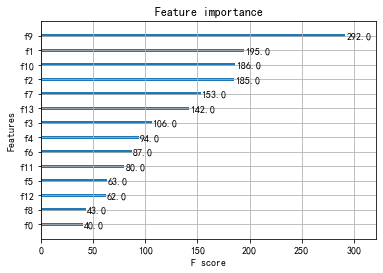

In [142]:
import xgboost as xgb
from xgboost import plot_importance

other_params = {'max_depth': 2, 'n_estimators': 600, 'scale_pos_weight': 5,'colsample_bytree': 0.8, 'gamma': 0.0001, 'min_child_weight': 5,'learning_rate': 0.01, 'subsample': 0.7}
xgboost_model = xgb.XGBClassifier(**other_params).fit(X_train,y_train)
#plot_importance(xgboost_model)
pred_xgboost = xgboost_model.predict(X_test)
xgb_test = xgboost_model.score(X_test,y_test)
xgb_test_pre = precision_score(y_test, pred_xgboost)
xgb_test_recall =  recall_score(y_test, pred_xgboost)
plot_importance(xgboost_model)

In [143]:
[xgb_test,xgb_test_pre,xgb_test_recall]

[0.7777777777777778, 0.42452830188679247, 0.5625]

In [144]:
[ accuracy_score(true_test,pred_xgboost),precision_score(true_test,pred_xgboost), recall_score(true_test,pred_xgboost)] 

[0.7870370370370371, 0.16037735849056603, 0.85]

# 对Xgboost进行调参

In [75]:
from sklearn.model_selection import GridSearchCV

other_params = {'max_depth': 2, 'n_estimators': 600, 'scale_pos_weight': 5,'colsample_bytree': 0.8, 'gamma': 0.0001, 'min_child_weight': 5,'learning_rate': 0.01, 'subsample': 0.7}
param_grid = {'subsample': [0.5,0.6,0.7,0.8,0.9],
              'learning_rate' : [1e-5,1e-4,1e-3,1e-2,1e-1]}
grid_search = GridSearchCV(xgboost_model,param_grid,n_jobs = -1,cv = 3,scoring = "f1")
grid_result = grid_search.fit(X_train, y_train)
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))


0.463351  with:   {'learning_rate': 1e-05, 'subsample': 0.5}
0.465953  with:   {'learning_rate': 1e-05, 'subsample': 0.6}
0.463225  with:   {'learning_rate': 1e-05, 'subsample': 0.7}
0.463046  with:   {'learning_rate': 1e-05, 'subsample': 0.8}
0.460831  with:   {'learning_rate': 1e-05, 'subsample': 0.9}
0.463351  with:   {'learning_rate': 0.0001, 'subsample': 0.5}
0.464820  with:   {'learning_rate': 0.0001, 'subsample': 0.6}
0.463225  with:   {'learning_rate': 0.0001, 'subsample': 0.7}
0.461714  with:   {'learning_rate': 0.0001, 'subsample': 0.8}
0.459415  with:   {'learning_rate': 0.0001, 'subsample': 0.9}
0.463549  with:   {'learning_rate': 0.001, 'subsample': 0.5}
0.463270  with:   {'learning_rate': 0.001, 'subsample': 0.6}
0.464563  with:   {'learning_rate': 0.001, 'subsample': 0.7}
0.464258  with:   {'learning_rate': 0.001, 'subsample': 0.8}
0.462983  with:   {'learning_rate': 0.001, 'subsample': 0.9}
0.466123  with:   {'learning_rate': 0.01, 'subsample': 0.5}
0.468762  with:   {'

In [ ]:
{'n_estimators': [400,500,600,700,800,900], 
              'scale_pos_weight': [4,5,6,7,8,9],
              'max_depth': [1,2,3,4,5,6], 
              'min_child_weight': [2,3,4,5,6],
              'colsample_bytree': [0.4,0.5,0.6,0.7,0.8],
              'gamma': [1e-4,1e-3,1e-2,1e-1,1],
              'subsample': [0.5,0.6,0.7,0.8,0.9],
              'learning_rate' : [1e-5,1e-4,1e-3,1e-2,1e-1]

In [76]:

print('最优参数组合:', grid_result.best_params_, '最好得分:', grid_result.best_score_)


最优参数组合: {'learning_rate': 0.01, 'subsample': 0.7} 最好得分: 0.4709395332071731


# 使用SVM进行训练

In [119]:
from sklearn import svm
clf = svm.SVC()
from sklearn.preprocessing import StandardScaler  # 归一化

# 归一化操作
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)
svm_train = clf.score(X_test,y_test)
svm_train_pre = precision_score(y_test, y_pred_svm)
svm_train_recall= recall_score(y_test, y_pred_svm)


In [120]:
[svm_train,svm_train_pre,svm_train_recall]

[0.8425925925925926, 0.8, 0.2]

In [145]:
[ accuracy_score(true_test,y_pred_svm),precision_score(true_test,y_pred_svm), recall_score(true_test,y_pred_svm)]

[0.9490740740740741, 0.45, 0.45]

# 使用XGBOD进行训练

In [152]:
from pyod.models.xgbod import XGBOD   # imprt kNN分类器
from sklearn.metrics import accuracy_score
# 训练一个kNN检测器
clf_name = 'XGBOD'
other_params = {'max_depth': 1, 'n_estimators': 500, 'scale_pos_weight': 4,'colsample_bytree': 0.4, 'gamma': 0.0001, 'min_child_weight': 2,'learning_rate': 0.01, 'subsample': 0.9}
clf = XGBOD(**other_params)
clf.fit(X_train,y_train) # 使用X_train训练检测器clf
pred_xgbod = clf.predict(X_test)  # outlier labels (0 or 1)
y_train_pred = clf.labels_
xgbod_precision= precision_score(y_test,pred_xgbod)
xgbod_acc = accuracy_score(y_test,pred_xgbod)
xgbod_recall = recall_score(y_test,pred_xgbod)

[17:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [153]:
[xgbod_acc,xgbod_precision,xgbod_recall]

[0.8078703703703703, 0.4819277108433735, 0.5]

In [154]:
[ accuracy_score(true_test,pred_xgbod),precision_score(true_test,pred_xgbod), recall_score(true_test,pred_xgbod)] 

[0.8402777777777778, 0.20481927710843373, 0.85]

# 整理测试集违约数据

In [69]:
result  = X_test
result["真实违约"] = true_test
result["中债下降"] = y_test
result["模型预测"] = y_test_pred
result.loc[result["真实违约"]==1]

,主营业务利润率,营业成本收入比,总资产报酬率,总资产收益率,应收账款周转率,存货周转率,流动比率,速度比率,EBITA/带息债务,资产负债率,短期债务/总债务,货币资金/总债务,货币资金/短期债务,营业收入增长率,真实违约,中债下降,模型预测
611,-58.0135,158.5524,-35.5538,-39.8015,373.9649,1.9386,0.8300,0.5396,-0.832706,106.2912,0.833081,0.022021,0.026433,-41.8275,1.0,1.0,1
3,-23.7977,125.4409,17.3928,13.1278,27.9557,7.2261,2.5257,1.9592,26.285066,20.8335,0.789756,1.100705,1.393728,9.7500,1.0,1.0,0
523,22.0206,301.0405,5.1804,0.3112,3.5272,1.7699,3.0921,1.9628,0.353929,37.5048,0.354617,0.365852,1.031683,-51.1783,1.0,1.0,0
820,-66.2396,183.6707,-16.1528,-19.2913,3.4081,2.1389,1.2872,1.1313,-0.522339,75.1412,0.954500,0.074219,0.077757,-71.4859,1.0,1.0,1
520,-15.2089,114.8067,-2.5883,-5.0791,1.6552,7.3391,0.8431,0.7594,-0.056568,53.7302,0.876651,0.068100,0.077682,-25.4666,1.0,1.0,1
509,-309.3032,422.0088,-77.2142,-140.1428,9.4145,0.9245,0.0642,0.0484,-0.197592,1049.5294,0.937625,0.020107,0.021445,9.9677,1.0,1.0,1
391,-532.5414,635.4254,-40.6484,-45.6245,0.3289,4.2922,0.6695,0.6550,-21.141796,80.0015,0.920276,0.045506,0.049448,-66.4338,1.0,1.0,1
308,-251.3136,437.6026,-96.7884,-94.0439,33.9548,4.9778,0.3145,0.2377,-2.066554,229.0134,0.565974,0.028755,0.050807,-0.2267,1.0,1.0,1
254,-134.2946,229.4077,-1.6373,-2.2666,3.1450,0.0213,1.2847,0.1312,-0.051073,90.7456,0.668612,0.014885,0.022263,-84.6975,1.0,1.0,1
688,15.5516,86.4426,9.3509,3.4466,63.1230,3.4359,0.5033,0.2756,0.232761,71.0742,0.602457,0.061970,0.102863,30.0184,1.0,0.0,0


#  f1 计算

In [123]:
def f1(pre,re):
    return 2*(re*pre)/(re+pre)
f1(0.45, 0.45)

0.45

# 对Xgbod进行调参

In [47]:
from sklearn.model_selection import GridSearchCV
other_params = {'max_depth': 1, 'n_estimators': 500, 'scale_pos_weight': 4,'colsample_bytree': 0.4, 'gamma': 0.0001, 'min_child_weight': 2,'learning_rate': 0.01, 'subsample': 0.9}
model = XGBOD(**other_params)

param_grid = {  'subsample': [0.5,0.6,0.7,0.8,0.9],
              'learning_rate' : [1e-5,1e-4,1e-3,1e-2,1e-1]}
grid_search = GridSearchCV(model,param_grid,n_jobs = -1,cv = 3,scoring = "f1")
grid_result = grid_search.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

[13:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.460146  with:   {'learning_rate': 1e-05, 'subsample': 0.5}
0.457583  with:   {'learning_rate': 1e-05, 'subsample': 0.6}
0.461562  with:   {'learning_rate': 1e-05, 'subsample': 0.7}
0.464081  with:   {'learning_rate': 1e-05, 'subsample': 0.8}
0.458015  with:   {'learning_rate': 1e-05, 'subsample': 0.9}
0.460146  with:   {'learning_rate': 0.0001, 'subsample': 0.5}
0.457583  with:   {'learning_rate': 0.0001, 'subsample': 0.6}
0.459000  with:   {'learning_rate': 0.0001, 'subsample': 0.7}
0.460164  with:   {'learning_rate': 0.0001, 'subsample': 0.8}
0.458015  with:   {'learning_rat

In [49]:
print('最优参数组合:', grid_result.best_params_, '最好得分:', grid_result.best_score_)


最优参数组合: {'learning_rate': 0.01, 'subsample': 0.9} 最好得分: 0.4824912426015082


# 绘制并比较预测结果

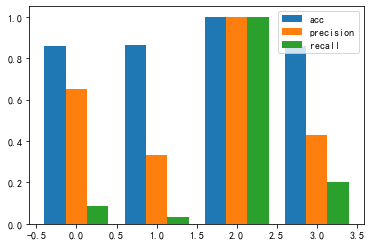

In [6]:

import matplotlib.pyplot as plt
size = 4
x = np.arange(size)
acc = [lr_train,lr_test,xgb_train,xgb_test]
precision = [lr_train_pre,lr_test_pre,xgb_train_pre,xgb_test_pre]
recall = [lr_train_recall,lr_test_recall,xgb_train_recall,xgb_test_recall]



total_width, n = 0.8, 3
width = total_width / n
x = x - (total_width - width) / 2

plt.bar(x, acc,  width=width, label='acc')
plt.bar(x + width, precision, width=width, label='precision')
plt.bar(x + 2 * width, recall, width=width, label='recall')
plt.legend()
plt.show()

In [7]:
recall

[0.08441558441558442, 0.03389830508474576, 1.0, 0.2033898305084746]

In [48]:
print('最优参数组合:', grid_result.best_params_, '最好得分:', grid_result.best_score_)

最优参数组合: {'learning_rate': 0.1} 最好得分: 0.5867356491746736


# 违约距离计算（暂时没用上）

In [8]:
import akshare as ak
for i in range(0,leng):
    try:    
        stock_zh_a_daily_qfq_df = ak.stock_zh_a_daily(symbol=code[i], start_date="20171231", end_date="20190101", adjust="qfq")
        stock_zh_a_daily_qfq_df["value"] = stock_zh_a_daily_qfq_df["outstanding_share"]*stock_zh_a_daily_qfq_df["close"]
        stock_zh_a_daily_qfq_df["next"] = stock_zh_a_daily_qfq_df["close"].shift(1)
        stock_zh_a_daily_qfq_df.dropna(inplace = True)
        n = len(stock_zh_a_daily_qfq_df["next"])
        rf = 1.5
        stock_zh_a_daily_qfq_df["change"] =(stock_zh_a_daily_qfq_df["close"]/stock_zh_a_daily_qfq_df["next"]-1)*100
        stock_zh_a_daily_qfq_df["change"] = (stock_zh_a_daily_qfq_df["change"]).apply(np.log1p) 
        std = stock_zh_a_daily_qfq_df["change"].std()
        mean = stock_zh_a_daily_qfq_df["close"].mean()
        sharp = (mean - rf)/std
        V_equity = mean*total_shar[i]
        default_point = (lib[i]-lt_lib[i])*1.045
        rf_rate = 0.015
        sigma_equity = std 
        T = 1
        # One dimension estimation
        def equation(x):
            d1 = (np.log(x[0]/default_point) + (rf_rate+x[1]**2/2)*T)/(x[1] * np.sqrt(T))
            d2 = d1 - x[1] * np.sqrt(T)
            res1 = x[0] * norm.cdf(d1) - np.exp(-rf_rate*T) * default_point * norm.cdf(d2) - V_equity
            res2 = x[0] * norm.cdf(d1) * x[1] - V_equity * sigma_equity
            return(res1**2+res2**2)
        result = minimize(equation,[V_equity,sigma_equity])
        V_asset = list(result["x"])[0]
        sigma_asset = list(result["x"])[1]
        DD = (V_asset-default_point)/(sigma_asset*V_asset)
        list_D.append(DD)
        sharp_list.append(sharp)
        record_code.append(code[i])
    except Exception as e:
        pass
    continue
DD

NameError: name 'leng' is not defined